<small><i>This notebook was put together by [Abel Meneses-Abad](http://www.menesesabad.com) for Paper *Paraphrase Beyond Sentence*. Source and license info is on [GitHub](https://github.com/sorice/2017paraphrasebsent/).</i></small>

# Classificating Paraphrase Sentences

In [2]:
%pylab inline
import pickle
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Loading preprocessed Data

In [30]:
data = open('data/strat-split-data.pkl', 'rb')
X_train, X_test, Y_train, Y_test = pickle.load(data)
data10 = open('data/strat-split-data10.pkl', 'rb')
Xn_train, Xn_test, Yn_train, Yn_test = pickle.load(data10)
data32 = open('data/strat-split-data32.pkl', 'rb')
Xnn_train, Xnn_test, Ynn_train, Ynn_test = pickle.load(data32)

## Clasification

multi_class = 'ovr' is set for this problem where there are only two binary classes.

In [36]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(max_iter=200, n_jobs=4, multi_class='ovr')
logreg10 = LogisticRegression(max_iter=200, n_jobs=4, multi_class='ovr')
logreg32 = LogisticRegression(max_iter=200, n_jobs=4, multi_class='ovr')
#New data after Feature Selection
#Xs_train, ys_train, Xs_test, ys_test = get_train_test(x_n,Y)

# fit the model with data
%timeit logreg.fit(X_train, Y_train)

198 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%timeit logreg10.fit(Xn_train, Yn_train)

199 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%timeit logreg32.fit(Xnn_train, Ynn_train)

188 ms ± 6.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Metrics Evaluation

In [35]:
from sklearn import metrics

# STEP 3: make predictions on the testing set
y_pred = logreg.predict(X_test)
yn_pred = logreg.predict(Xn_test)
ynn_pred = logreg.predict(Xnn_test)

# compare actual response values (y_test) with predicted response values (y_pred)
print(metrics.accuracy_score(Y_test, y_pred))
print(metrics.accuracy_score(Yn_test, yn_pred))
print(metrics.accuracy_score(Ynn_test, ynn_pred))

0.743663594470046
0.743663594470046
0.743663594470046


In [40]:
metrics.f1_score(Yn_test, yn_pred)

0.8200566114031541

In [25]:
metrics.roc_curve(Y_test, y_pred)

(array([0.        , 0.48421053, 1.        ]),
 array([0.        , 0.87371134, 1.        ]),
 array([2, 1, 0]))

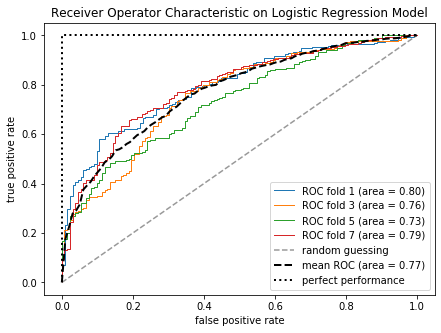

In [15]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

X_train2 = X_train#[:, [4, 14]] #Modified this to have feature selection

skfolds = StratifiedKFold(n_splits=10)

fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1, max_iter=200, n_jobs=4, multi_class='ovr'))])

for i, (train, test) in enumerate(skfolds.split(X_train2,Y_train)):
    probas = pipe_lr.fit(X_train2[train],Y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(Y_train[test],probas[:, 1],pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if i in [0,2,4,6]:
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
mean_tpr /= 10
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1], lw=2, ls=':', color='black', label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic on Logistic Regression Model')
plt.legend(loc="lower right")
plt.show()

In [16]:
from sklearn.svm import SVC # "Support Vector Classifier"

# instantiate the model (using the default parameters)
clf = SVC(kernel='linear')

#New data after Feature Selection
#Xs_train, ys_train, Xs_test, ys_test = get_train_test(x_n,Y)

# fit the model with data
clf.fit(X_train, Y_train)

# STEP 3: make predictions on the testing set
y_pred = clf.predict(X_test)

# compare actual response values (y_test) with predicted response values (y_pred)
print(metrics.accuracy_score(Y_test, y_pred))
print(metrics.f1_score(Y_test, y_pred))

0.7540322580645161
0.8287204171680705


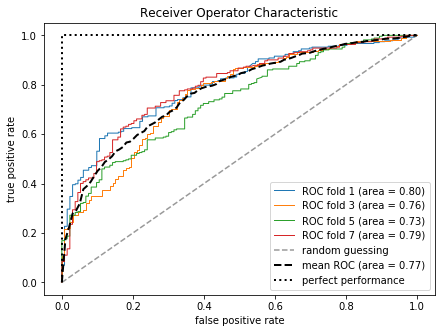

In [17]:
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', SVC(kernel='linear', probability=True))])

for i, (train, test) in enumerate(skfolds.split(X_train2,Y_train)):
    probas = pipe_lr.fit(X_train2[train],Y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(Y_train[test],probas[:, 1],pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if i in [0,2,4,6]:
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
mean_tpr /= 10 # of kfolds
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1], lw=2, ls=':', color='black', label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

In [18]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (using the default parameters)
knn = KNeighborsClassifier(n_neighbors=30)

#New data after Feature Selection
#Xs_train, ys_train, Xs_test, ys_test = get_train_test(x_n,Y)

# fit the model with data
knn.fit(X_train, Y_train)

# STEP 3: make predictions on the testing set
y_pred = knn.predict(X_test)

# compare actual response values (y_test) with predicted response values (y_pred)
print(metrics.accuracy_score(Y_test, y_pred))
print(metrics.f1_score(Y_test, y_pred))

0.7240783410138248
0.8096940802542709


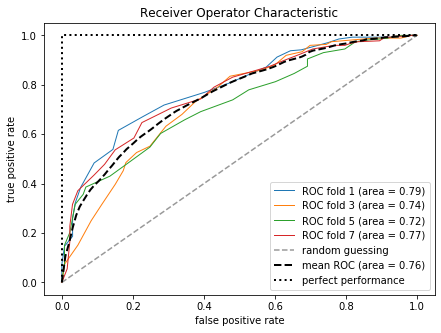

In [19]:
from sklearn.neighbors import KNeighborsClassifier

fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', KNeighborsClassifier(n_neighbors=30))])

for i, (train, test) in enumerate(skfolds.split(X_train2,Y_train)):
    probas = pipe_lr.fit(X_train2[train],Y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(Y_train[test],probas[:, 1],pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if i in [0,2,4,6]:
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
mean_tpr /= 10
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1], lw=2, ls=':', color='black', label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

# Conclusions

The comparation between *Logistic Regression* and *Support Vector Classifier* shows that accuracy & F-measure is higer in SVM. ROC is the same in both.

Based on this analysis SVM is better but, the recursive experimentation shows that the models are uncapable to capture more than 77% of the cases. The only possible change is to generate new and different features of our objects.

# Recomendations

* Read more about AUC: [ROC sklearn](file:///usr/share/doc/python-sklearn-doc/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc), and try to understand why so many studies consider better this metric over ROC.
* Read the rest of [sklearn classification metrics](file:///usr/share/doc/python-sklearn-doc/stable/modules/model_evaluation.html#classification-metrics)

In [28]:
#saving obtained clean data for future notebooks
import pickle
pickle.dump(clf, open('data/svc_model.pkl', 'wb'))
pickle.dump(logreg, open('data/logreg_model.pkl', 'wb')) 

# Questions
* Test more metrics contained in sklearn: [cross validation metrics](file:///usr/share/doc/python-sklearn-doc/stable/modules/cross_validation.html#computing-cross-validated-metrics)
* Calc AUC in the same data with the same model.
* Test another sklearn supervised models, like Naive Bayes, Decision Trees, and analyse the results.
* Try an ensemble method and see if you can improved the results of accuracy or F measure. 

# References and Resources

* Sebastian Raschka, Book "Python Machine Learning". Packt Publishing, 2015.
<a id='Raschka2015'></a>

* Justin Markham, online course [Introduction to machine learning with scikit-learn](http://nbviewer.ipython.org/github/justmarkham/scikit-learn-videos/tree/master/), first edition 2015.

__Notes:__ Some ideas of this notebook are taken from Raschka book, but the codes have been updated for current versions of sklearn. 